In [5]:
%load_ext autoreload

In [6]:
import pandas as pd
import re

In [7]:
# here's the data with all agents
filename = """
generative-social-choice/generative_social_choice/experiments/prolific_approval_query_eval/2023-10-11-20:19:14__chatbot_personalization_eval_23_09_28_strict__50/logs.csv
"""

# here's the data with half agents, that's done
# filename = """generative-social-choice/generative_social_choice/experiments/prolific_approval_query_eval/2023-09-26-15:01:44__chatbot_personalization_rating_23_09_25__10/logs.csv"""
filename = filename[filename.index("2023") :].replace("\n", "")

In [8]:
df = pd.read_csv(filename, index_col=0)
# Agent_id consists of {id}_{question_idx}, we just want the agent
df["agent_id"] = df["id"].apply(lambda s: s.split("_")[0])
df["choice_number"] = (
    df["choice_number"].astype(str).apply(lambda x: re.sub("[^0-9]", "", x)).astype(int)
)
model = df["model"].unique()[0]

## Aggregate multiple attempts at the same query

If multiple trials for the same query, take the median of the outputs. 

In [9]:
grouped_id = df.groupby("id")
group_median = (
    df.groupby("id")["choice_number"].median().reset_index(name="median_choice_number")
)
df = df.merge(group_median, on="id")

## attempt 1: just see how many perfect matches

In [10]:
df["choice_match"] = df["median_choice_number"] == df["correct_choice"]
df.groupby("agent_id")["choice_match"].agg(["mean", "std"])

,mean,std
agent_id,,
56ee521a65ca4d000cc39e55,0.500000,0.707107
5716afefc5aca2000a8d4546,1.000000,NaN
5b33034d975e260001e981c9,0.250000,0.500000
5b666901f7798c000182c01c,0.000000,0.000000
5c3820ee1ede2b0001155929,0.500000,0.707107
5dea10b4446c9012dc5e3fe3,0.500000,0.707107
5e6b034bffc1a90c3fe8c234,0.000000,0.000000
5ed696d2449ef00dbdce0178,0.333333,0.577350
5eda5c5faf7c7f08a2f68cb7,0.750000,0.500000


In [11]:
df["choice_match"].mean()

0.32

Random guessing would be 25%. 

## attempt 2: compute distance

In [92]:
df["choice_dist"] = abs(df["median_choice_number"] - df["correct_choice"])

In [93]:
df.groupby("agent_id")["choice_dist"].agg(["mean", "std"])

,mean,std
agent_id,,
56ee521a65ca4d000cc39e55,1.000000,NaN
5716afefc5aca2000a8d4546,0.000000,0.000000
5b33034d975e260001e981c9,0.000000,0.000000
5b666901f7798c000182c01c,0.000000,NaN
5c3820ee1ede2b0001155929,0.333333,0.577350
5dea10b4446c9012dc5e3fe3,0.500000,0.707107
5e6b034bffc1a90c3fe8c234,2.000000,1.414214
5ed696d2449ef00dbdce0178,1.000000,1.000000
5eda5c5faf7c7f08a2f68cb7,1.000000,1.154701


If it was guessing randomly, and if the options were equally likely, then the mean choice distance would be 
- If truth is 1: avg choice dist 1.5=(0+1+2+3)/4
- If truth is 2: avg choice dist 1 = (1+0+1+2)/4
- Same for 3,4 

**=> MEAN CHOICE DISTANCE WOULD BE 1.25 if guessing randomly**

In [94]:
df["choice_dist"].mean()

0.84

In [95]:
choice_to_freq = (
    df["correct_choice"].value_counts() / len(df["correct_choice"])
).to_dict()
for choice in [1, 2, 3, 4]:
    if choice not in choice_to_freq:
        choice_to_freq[choice] = 0
choice_to_freq
choice_to_expected_dist = {1: 1.5, 2: 1, 3: 1, 4: 1.5}

Here is the expected distance from guessing randomly, using the correct priors:

In [96]:
expected_dist = sum(
    [
        choice_to_freq[choice] * choice_to_expected_dist[choice]
        for choice in [1, 2, 3, 4]
    ]
)
expected_dist

1.1300000000000001

## todo: paul wants a heat map of "truth" vs "actual"

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [102]:
freq_table = pd.crosstab(index=df["correct_choice"], columns=df["median_choice_number"])
desired_labels = sorted(df["correct_choice"].unique())
freq_table = freq_table.reindex(columns=desired_labels, fill_value=0)
freq_table = freq_table.sort_index()

Raw heatmap

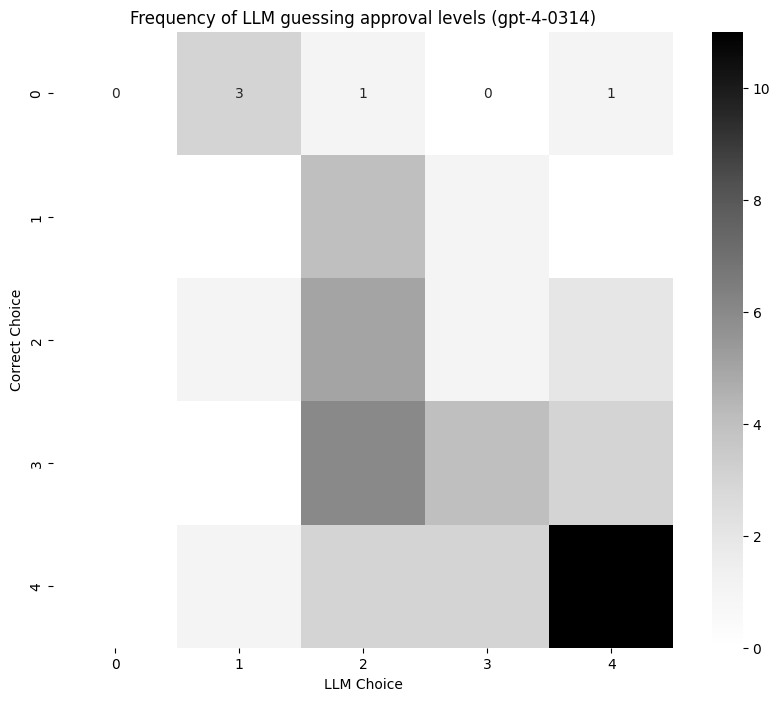

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(freq_table, annot=True, fmt="d", cmap="Greys")
plt.xlabel("LLM Choice")
plt.ylabel("Correct Choice")
plt.title(f"Frequency of LLM guessing approval levels ({model})")
plt.show()

Normalized heatmap

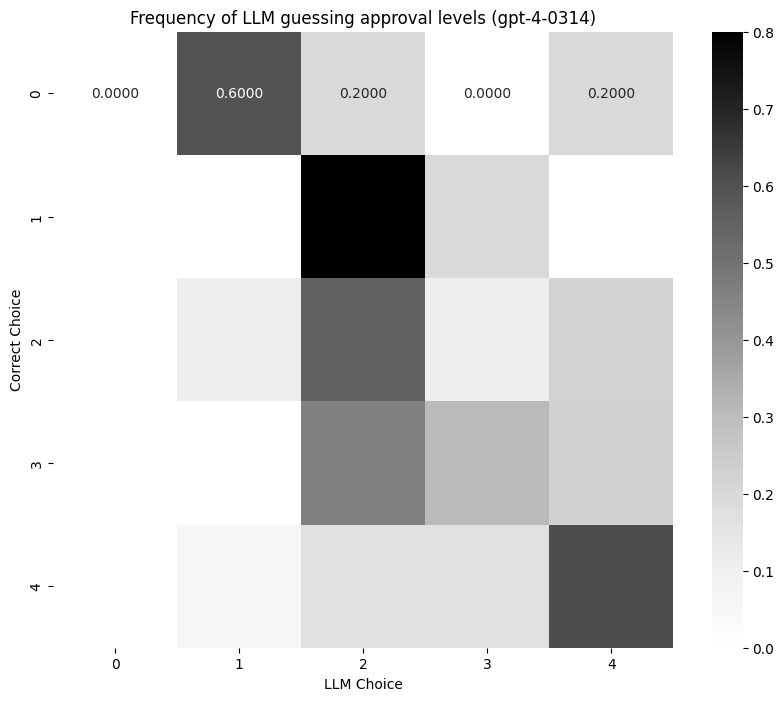

In [104]:
# row-normalize table
norm_table = (freq_table.T / freq_table.sum(axis=1)).T

plt.figure(figsize=(10, 8))
sns.heatmap(norm_table, annot=True, fmt=".4f", cmap="Greys")
plt.xlabel("LLM Choice")
plt.ylabel("Correct Choice")
plt.title(f"Frequency of LLM guessing approval levels ({model})")
plt.show()